In [1]:
import numpy as np
from numpy import random
import time
import pickle
import os
import pathlib
import inspect

from Performance import DDR_Problem_Evaluation
ddr_eva = DDR_Problem_Evaluation()
from OLS import ols_method
from DDR import ddr_method

from SPO import SPO_plus_method
from Figures import regret_and_h2h_figure
regret_h2h = regret_and_h2h_figure()

## Generate Data

In [2]:
def generate_data(DataPath,iters,lower, upper, p, d, data_generation_process,
                  samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp):
    from Data import data_generation
    data_gen = data_generation()
    Data = {}
    for i in range(iters):
        # print("============== iteration = ",i,"==============")
        file_path = DataPath + "iter="+str(i) +"/"
        pathlib.Path(file_path).mkdir(parents=True, exist_ok=True)
        # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
        W_star = data_gen.generate_truth(lower, upper, p, d, data_generation_process) 
        Data[i] = data_gen.generate_samples(file_path,p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                            data_generation_process, x_dister, e_dister, xl, xu, xm, xv, bp) 
    return Data

## Oracle

In [3]:
def Implement_Oracle(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    cost_Oracle_with_noise_all = {}; cost_Oracle_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_Oracle_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(z_test_ori,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        cost_Oracle_with_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(z_test_ori,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_oracle_without_noise = ",np.nanmean(cost_Oracle_wo_noise_all[i]))
        #     print(fold_name,",iteration = ",i,",c_oracle_with_noise = ",np.nanmean(cost_Oracle_with_noise_all[i]))

    with open(Data_path_child+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_with_noise_all,tf)
    with open(Data_path_child+'cost_Oracle_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_wo_noise_all,tf)
    return cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all

## OLS

In [4]:
def Implement_OLS(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ols_method_obj = ols_method()
    cost_OLS_with_noise_all = {}; cost_OLS_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ols, w0_ols, t_ols, obj_ols = ols_method_obj.ols_solver("",x_train, z_train)
        cost_pred = (W_ols @ x_test.T).T + w0_ols
        cost_OLS_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        cost_OLS_with_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_OLS_without_noise = ",np.nanmean(cost_OLS_wo_noise_all[i]))
        #     print(fold_name,",iteration = ",i,",c_OLS_with_noise = ",np.nanmean(cost_OLS_with_noise_all[i]))
    with open(Data_path_child+'cost_OLS_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_wo_noise_all,tf)
    with open(Data_path_child+'cost_OLS_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_with_noise_all,tf)
    return cost_OLS_with_noise_all,cost_OLS_wo_noise_all

## Lasso

In [5]:
def Implement_Lasso(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ols_method_obj = ols_method()
    cost_Lasso_with_noise_all = {}; cost_Lasso_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_lasso, w0_lasso, t_lasso = ols_method_obj.lasso_solver(x_train, z_train)
        cost_pred = (W_lasso @ x_test.T).T + w0_lasso
        cost_Lasso_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        cost_Lasso_with_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_Lasso_without_noise = ",np.nanmean(cost_Lasso_wo_noise_all[i]))
        #     print(fold_name,",iteration = ",i,",c_Lasso_with_noise = ",np.nanmean(cost_Lasso_with_noise_all[i]))

    with open(Data_path_child+'cost_Lasso_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Lasso_wo_noise_all,tf)
    with open(Data_path_child+'cost_Lasso_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Lasso_with_noise_all,tf)
    return cost_Lasso_with_noise_all,cost_Lasso_wo_noise_all

## Ridge

In [6]:
def Implement_Ridge(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ols_method_obj = ols_method()
    cost_Ridge_with_noise_all = {}; cost_Ridge_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ridge, w0_ridge, t_ridge = ols_method_obj.ridge_solver(x_train, z_train)
        cost_pred = (W_ridge @ x_test.T).T + w0_ridge
        cost_Ridge_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        cost_Ridge_with_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",c_Ridge_without_noise = ",np.nanmean(cost_Ridge_wo_noise_all[i]))
        #     print(fold_name,",iteration = ",i,",c_Ridge_with_noise = ",np.nanmean(cost_Ridge_with_noise_all[i]))

    with open(Data_path_child+'cost_Ridge_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Ridge_wo_noise_all,tf)
    with open(Data_path_child+'cost_Ridge_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Ridge_with_noise_all,tf)
    return cost_Ridge_with_noise_all,cost_Ridge_wo_noise_all

## DDR

In [7]:
def Implement_DDR(iters,Data,data_generation_process,DataPath,fold_name,mu_all,lamb_all):
    Data_path_child = DataPath + fold_name
    ddr_method_obj = ddr_method()
    W_ddr_all = {}; w0_ddr_all = {}; obj_ddr_all = {}
    cost_DDR_wo_noise_all = {}; cost_DDR_with_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_ddr_avg_tem = np.zeros((len(mu_all),len(lamb_all)))
        for mu_index in range(len(mu_all)):
            mu = mu_all[mu_index]
            for lamb_index in range(len(lamb_all)):
                lamb = lamb_all[lamb_index]
                W_ddr_all[i,mu,lamb], w0_ddr_all[i,mu,lamb] = ddr_method_obj.ddr_solver(x_train, z_train, mu, lamb)
                cost_pred = (W_ddr_all[i,mu,lamb] @ x_test.T).T + w0_ddr_all[i,mu,lamb]
                cost_DDR_wo_noise_all[i,mu,lamb] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
                cost_DDR_with_noise_all[i,mu,lamb] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",cost_DDR_wo_noise_all = ",np.nanmean(cost_DDR_wo_noise_all[i,mu,lamb]))
        #     print(fold_name,",iteration = ",i,",cost_DDR_with_noise_all = ",np.nanmean(cost_DDR_with_noise_all[i,mu,lamb]))

    with open(Data_path_child+'cost_DDR_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_wo_noise_all,tf)
    with open(Data_path_child+'cost_DDR_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_with_noise_all,tf)
    return cost_DDR_with_noise_all,cost_DDR_wo_noise_all

## SPO Plus

In [8]:
def Implement_SPO_plus(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    spo_method_obj = SPO_plus_method()
    cost_SPO_with_noise_all = {}; cost_SPO_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        y_train_opt = ddr_eva.decision_finder(z_train) #generates the optimal y from the training costs
        W_spo, w0_spo, t_spo = spo_method_obj.spo_solver(x_train, z_train, y_train_opt)
        cost_pred = (W_spo @ x_test.T).T + w0_spo
        cost_SPO_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        cost_SPO_with_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,True)
        # if i % 100 == 0:
        #     print(fold_name,",iteration = ",i,",cost_SPO_wo_noise_all = ",np.nanmean(cost_SPO_wo_noise_all[i]))
        #     print(fold_name,",iteration = ",i,",cost_SPO_with_noise_all = ",np.nanmean(cost_SPO_with_noise_all[i]))

    with open(Data_path_child+'cost_SPO_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_wo_noise_all,tf)
    with open(Data_path_child+'cost_SPO_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_with_noise_all,tf)
    return cost_SPO_with_noise_all,cost_SPO_wo_noise_all

## Comparison

In [9]:
seed = 3
random.seed(seed)

iters = 100
samples_test = 10000
thres = samples_test
lower = 0
upper = 1
n_epsilon = 1
mis = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
bp = 7

d = 10
alpha = 1
samples_train = 100
p = 4
mis_all = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]

mu_all = np.round(np.arange(0.25,0.251,0.1),4)
lamb_all = np.round(np.arange(0.25,0.251,0.1),4)
data_generation_process = "DDR_Data_Generation"
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/DDR_Problem_Reproduce_' + data_generation_process +"_Figure5/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/DDR_Problem_Reproduce_DDR_Data_Generation_Figure5/


In [10]:
mu = mu_all[0]
lamb = lamb_all[0]
h2h_ddr_ols = np.zeros(len(mis_all))
regret_ddr_ols = np.zeros(len(mis_all))
# Data = {}
mis_index = 0
for mis in mis_all:
    random.seed(seed)
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_mis="+str(mis)+"/"
    Data = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process,
        samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)
    
    cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all = Implement_Oracle(iters,Data,data_generation_process,DataPath,fold_name)
    cost_OLS_with_noise_all,cost_OLS_wo_noise_all = Implement_OLS(iters,Data,data_generation_process,DataPath,fold_name)
    cost_DDR_with_noise_all,cost_DDR_wo_noise_all = Implement_DDR(iters,Data,data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    
    win_ratio_ddr_ols_wo_noise = np.zeros(iters); cost_reduction_ddr_ols_wo_noise = np.zeros(iters); regret_reduction_ddr_ols_wo_noise = np.zeros(iters)
    for i in range(iters):
        lbel, win_ratio_ddr_ols_wo_noise[i], cost_reduction_ddr_ols_wo_noise[i], regret_reduction_ddr_ols_wo_noise[i] = ddr_eva.cross_compare2plus(cost_DDR_wo_noise_all[i,mu,lamb],cost_OLS_wo_noise_all[i],cost_Oracle_wo_noise_all[i])
    regret_ddr_ols[mis_index] = np.round( len(regret_reduction_ddr_ols_wo_noise[regret_reduction_ddr_ols_wo_noise > 0.0])/len(regret_reduction_ddr_ols_wo_noise),4 )
    h2h_ddr_ols[mis_index] = np.round( len(win_ratio_ddr_ols_wo_noise[win_ratio_ddr_ols_wo_noise > 0.5])/len(win_ratio_ddr_ols_wo_noise),4 )
    
    print("mis=",mis,",h2h=",h2h_ddr_ols[mis_index],",regret=",regret_ddr_ols[mis_index])
    mis_index = mis_index + 1

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
mis= 0.4 ,h2h= 0.59 ,regret= 0.62
mis= 0.6 ,h2h= 0.68 ,regret= 0.72
mis= 0.8 ,h2h= 0.65 ,regret= 0.66
mis= 1 ,h2h= 0.72 ,regret= 0.72
mis= 1.2 ,h2h= 0.56 ,regret= 0.59
mis= 1.4 ,h2h= 0.52 ,regret= 0.5
mis= 1.8 ,h2h= 0.31 ,regret= 0.33
mis= 2.0 ,h2h= 0.33 ,regret= 0.31
mis= 2.5 ,h2h= 0.37 ,regret= 0.47
mis= 3.0 ,h2h= 0.25 ,regret= 0.32
mis= 3.5 ,h2h= 0.07 ,regret= 0.11
mis= 4.0 ,h2h= 0.07 ,regret= 0.07


/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_81212/292602237.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')


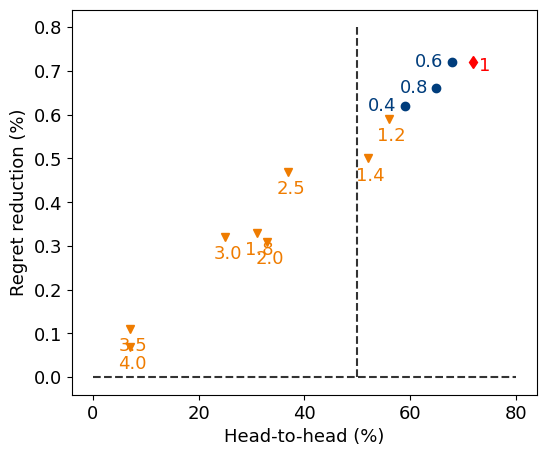

In [ ]:
import matplotlib.pyplot as plt
h2h = h2h_ddr_ols * 100
pio = regret_ddr_ols
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] - 7, pio[i] - 0.01,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 0.02, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 2.2, pio[7] - 0.05, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 2.2, pio[i] - 0.05, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, 0.0, 0.8, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(0.0, 0, 80, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig('430_mis_ddrols.eps', format='eps', bbox_inches="tight")